In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
df = pd.read_csv('car-price_data.csv')

sel_df = df[['Make', 'Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']]
sel_df.columns = sel_df.columns.str.replace(' ', '_').str.lower()
string_columns = list(sel_df.dtypes[sel_df.dtypes == 'object'].index)

for col in string_columns:
    sel_df[col] = sel_df[col].str.lower().str.replace(' ', '_')

sel_df = sel_df.fillna(0)
sel_df = sel_df.rename(columns={'msrp': 'price'})
sel_df['above_average'] = (sel_df.price > sel_df.price.mean()).astype('int')

C:\Users\ahmed\AppData\Local\Temp\ipykernel_9576\453902640.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df[col] = sel_df[col].str.lower().str.replace(' ', '_')


In [3]:
df_train_full, df_test = train_test_split(sel_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']
del df_train['price']
del df_val['price']
del df_test['price']

In [4]:
df_train_full.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
price                  int64
above_average          int32
dtype: object

In [5]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model','transmission_type', 'vehicle_style']

In [6]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [41]:
val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
  
y_pred = model.predict_proba(X_val)[:, 1]
above_average = (y_pred >= 0.5)
(y_val == above_average).mean()
# y_pred = model.predict(X_val)
# print(round(metrics.accuracy_score(y_val, y_pred),3))
print(round(metrics.roc_auc_score(y_val, y_pred),3))

0.976


Confusion Table

In [8]:
metrics.confusion_matrix(y_val, above_average)

array([[1657,   72],
       [  86,  568]], dtype=int64)

In [9]:
con_mat = (metrics.confusion_matrix(y_val, above_average)/metrics.confusion_matrix(y_val, above_average).sum()).round(2)

In [55]:
con_mat

array([[0.7 , 0.03],
       [0.04, 0.24]])

In [10]:
con_mat[0][0]+con_mat[1][1] # sum of correct predictions == accuracy

0.94

precision and recall

In [42]:
thresholds = np.linspace(0, 1,101)
scores = []

for t in thresholds:
    precision = metrics.precision_score(y_val, y_pred >= t)
    recall = metrics.recall_score(y_val, y_pred >= t)
    f1_score = metrics.f1_score(y_val, y_pred >= t)
    scores.append((t, precision, recall, f1_score))

columns = ['threshold', 'precision', 'recall', 'f1_score']
df_scores = pd.DataFrame(scores, columns=columns)

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


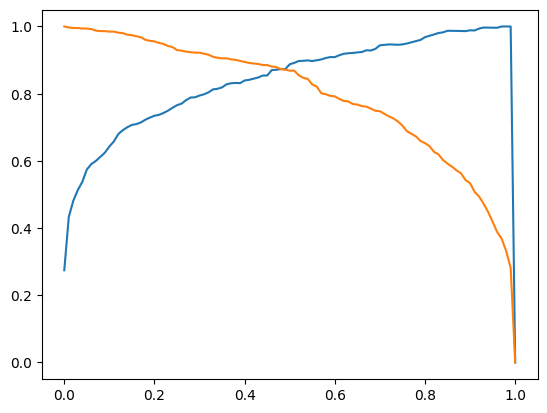

In [44]:
plt.plot(df_scores['threshold'], df_scores['precision'])
plt.plot(df_scores['threshold'], df_scores['recall'])
plt.show()

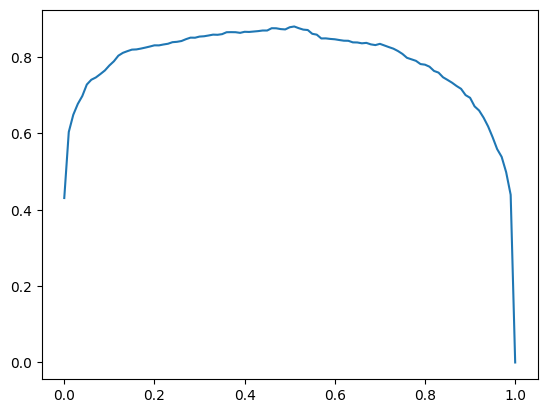

In [45]:
plt.plot(df_scores['threshold'], df_scores['f1_score'])

In [47]:
print(df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()])
print(df_scores[df_scores['precision'] == df_scores['recall']])

    threshold  precision    recall  f1_score
51       0.51    0.89168  0.868502  0.879938
     threshold  precision    recall  f1_score
48        0.48   0.873089  0.873089  0.873089
100       1.00   0.000000  0.000000  0.000000
